In [1]:
# importing needed modules 
import requests
import pandas as pd
import numpy as np
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt

# API Key from visual crossing weather API 
weatherAPI = "GRAAJQAWCEUR34FCN9Z42XDWA"


In [89]:
# Overall project plan: 

# Question to be asked: 
    # How does the location, elevation, and elevation range (vertical) correlate to average 
    # snowfall/precipitation and average temperatures?
    
    # Are there trends of lower precipitation and higher average temperatures?
        # Where are we seeing these trends the most?
        
    # Maybe figure out where the most reliable place is to ski, meaning which resort gets the most precipitation, on average,
    # or what days receive the most snowfall. 
    
    
# Also just a note, some of the API function calls take a few seconds as I am iterating over a lot of information

In [3]:
# Due to API request limitations, and available data, 
# I will only be working with one ski resort in each state, as well as only looking at data over the past 20 years (with API),
# and the past 10 years with the annualsnow.csv file 

In [4]:
# read the .csv file using pandas
skiResortLocationDF = pd.read_csv("ski_resort_stats.csv")

In [5]:
# As we can see, each row returns data about a specific ski resort in the US
# This data that we will be using from this data frame 
# consists of the state, resort name, summmit, base, and vertical (all in ft), as well as the latitude and longitude of the resort 
skiResortLocationDF

,resort_name,state,summit,base,vertical,lifts,runs,acres,green_percent,green_acres,blue_percent,blue_acres,black_percent,black_acres,lat,lon
0,"49(degrees) North, WA",Washington,5774.0,3923.0,1851.0,6.0,68.0,2325,0.30,697.50,0.40,930.00,0.30,697.50,49.00,-115.84
1,"Afton Alps, MN",Minnesota,700.0,350.0,350.0,21.0,48.0,300,0.20,60.00,0.60,180.00,0.20,60.00,44.85,-92.79
2,"Alpine Meadows, CA",California,8673.0,6385.0,2288.0,13.0,100.0,2400,0.25,600.00,0.40,960.00,0.35,840.00,39.17,-120.22
3,"Alpine Mountain, PA",Pennsylvania,1150.0,600.0,500.0,3.0,21.0,120,0.17,20.40,0.55,66.00,0.28,33.60,40.08,-76.90
4,"Alpine Valley, MI",Michigan,1210.0,910.0,300.0,14.0,25.0,118,0.39,46.02,0.26,30.68,0.35,41.30,44.96,-84.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,"Wolf Mt, UT",Utah,6400.0,5400.0,1000.0,4.0,22.0,110,0.35,38.50,0.45,49.50,0.20,22.00,40.48,-111.02
360,"Wolf Ridge, NC",North Carolina,4700.0,4000.0,700.0,5.0,22.0,72,0.55,39.60,0.36,25.92,0.09,6.48,5.95,-82.50
361,"Woodbury, CT",Connecticut,850.0,550.0,300.0,6.0,15.0,100,0.33,33.00,0.34,34.00,0.33,33.00,41.55,-73.22
362,"Woods Valley, NY",New York,1400.0,900.0,500.0,3.0,11.0,25,0.20,5.00,0.60,15.00,0.20,5.00,43.59,-73.67


In [6]:
# As I only have so many API requests, I need to narrow down which resorts that I will work with
# I am going to be working with ski resorts focused in the western parts (all similar longitude) of America: 
    # Steamboat, CO 
    # Vail, CO 
    # Alyeska, AK 
    # Mammoth, CA
    # Crystal Mountain, WA
    
# These resorts have varying latitudes and varying base elevations and change in vertical feet (from base to summit)
# These resorts also are either on the Epic or Ikon ski pass, which will be beneficial when working with a dataframe later on

# resort names into a list
resort_names = ["Steamboat, CO","Vail, CO","Alyeska, AK","Mammoth, CA","Crystal Mountain, WA"]

# make a new dataframe that only includes these resorts 
# use .isin function to extract the resorts with names specified in list above 
# .reset the index so we can use .iloc later, to get data on specific resorts 
resortsDF = skiResortLocationDF[(skiResortLocationDF["resort_name"].isin(resort_names))].reset_index()
resortsDF

,index,resort_name,state,summit,base,vertical,lifts,runs,acres,green_percent,green_acres,blue_percent,blue_acres,black_percent,black_acres,lat,lon
0,8,"Alyeska, AK",Alaska,3939.0,250.0,2500.0,9.0,73.0,1500,0.11,165.00,0.52,780.00,0.37,555.00,60.97,-149.11
1,96,"Crystal Mountain, WA",Washington,7012.0,4400.0,3100.0,12.0,57.0,2600,0.11,286.00,0.54,1404.00,0.35,910.00,46.92,-121.52
2,169,"Mammoth, CA",California,11053.0,7953.0,3100.0,28.0,150.0,3500,0.25,875.00,0.40,1400.00,0.35,1225.00,41.73,-121.37
3,293,"Steamboat, CO",Colorado,10568.0,6900.0,3668.0,18.0,165.0,2965,0.14,415.10,0.42,1245.30,0.44,1304.60,40.80,-106.95
4,334,"Vail, CO",Colorado,11570.0,8120.0,3450.0,31.0,193.0,5289,0.18,952.02,0.29,1533.81,0.53,2803.17,39.64,-106.36


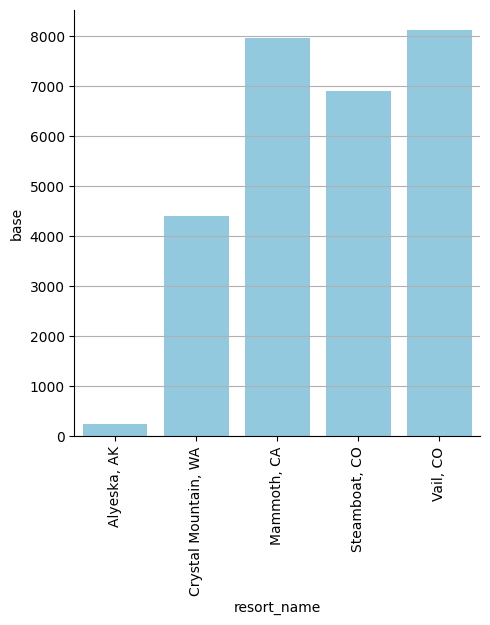

In [7]:
# Let's visualize the difference in base elevation (how high from sea level the base of the resort lies)

# graph a bar plot to compare the different values relative to each other 
# rotate labels to read clearly 
sb.catplot(x="resort_name", y="base", data=resortsDF, color="skyblue",kind="bar").set_xticklabels(rotation=90)
# Add grid on y-axis to help visualize even further 
plt.grid(axis="y")  

In [8]:
# As we can see, Alyeska has the lowest base elevation by a significant amount, while Vail and Mammoth have 
# the highest base elevation. We will return to this table later 

In [9]:
avgLatitude = np.mean(skiResortLocationDF["lat"])
avgLatitude

42.726686280991736

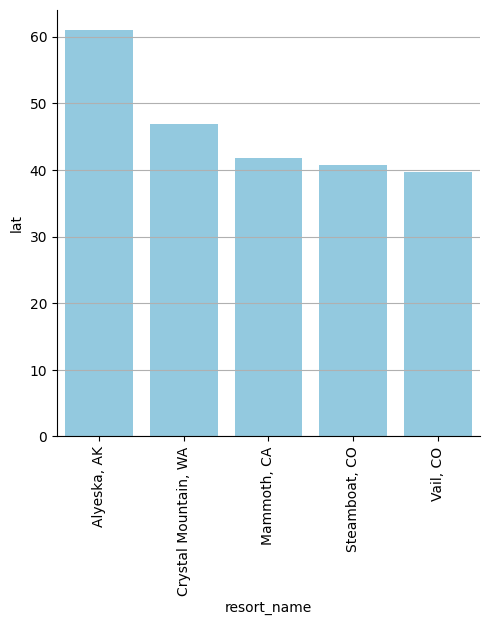

In [10]:
# visualize the latitude, also using a bar chart (same graphing process as above)
sb.catplot(x="resort_name",y="lat",data=resortsDF,kind="bar",color="skyblue",).set_xticklabels(rotation=90)
plt.grid(axis="y")
# as we can see, two of the resorts we will be looking at fall around the average latitude of the resorts on this data frame
# one latitude is much higher than the average (Alyeska), which is also interesting, as it has the lowest base elevation. 

In [11]:
# Now, let's get some information on the precipitation and temperature from visual crossing weather API
# when using the weather api, all requests will use this base request (taken from the documentation page on the API website)
base_url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"

In [12]:
# the json file only gives us at most daily averages, so we are going to have to get the temperature and precipiation
# of every day for each year, taking the averages as we go 

# first, we can write a function that returns a json file for every day of just one year specified by an argument
def getYearlyData(lat,lon,year):
    # use .format to put the year into the start and end date
    start_date = "{}-01-01".format(year)
    end_date = "{}-12-31".format(year)
    # this request returns a json() file that is a dictionary. The temperature and precipitation is within a list in the 
    # days "key"
    data = requests.get(base_url+str(lat)+","+str(lon)+"/"+start_date+"/"+end_date+"?key="+weatherAPI+"&include=days").json()
    return data 

In [13]:
# then we can make a function that will go through each day and calculate average temperature for the year 
def calculateMeanTemperature(lat,lon,year):
    # get the json() file for specified year
    yearly_data = getYearlyData(lat,lon,year)
    # iterate through the list of temperatures and append to a list 
    temperatures = [day["temp"] for day in yearly_data["days"]]
    # take the average of the temperatures from each day, and return 
    average_temperature = np.mean(temperatures)
    return average_temperature

In [14]:
# Let's visualize! 
start_year = 2000 
end_year = 2020 
# create a dictionary that includes the year 
# iterate using for __ in __ 
# we want to find the average valeus from 2000 to 2020, and to make sure we include 2020, we add 1 to the end year in the loop 
# use .iloc[0] to get Alyeska data (Alyeska is the first thing resort in the dataframe)
average_temperatures_Alyeska = {year: calculateMeanTemperature(resortsDF.iloc[0]["lat"],resortsDF.iloc[0]["lon"],year)
                        for year in range(start_year, end_year + 1)}

In [15]:
# see what the dictionary looks like
# key is the year, its value is the average temperature for that entire year
average_temperatures_Alyeska

{2000: 39.15273224043716,
 2001: 38.03917808219178,
 2002: 40.113698630136994,
 2003: 40.17506849315069,
 2004: 38.993169398907106,
 2005: 39.926849315068495,
 2006: 36.154794520547945,
 2007: 37.59835616438356,
 2008: 35.11338797814207,
 2009: 36.697534246575344,
 2010: 36.92219178082192,
 2011: 36.1841095890411,
 2012: 32.988251366120224,
 2013: 37.80246575342466,
 2014: 39.892876712328764,
 2015: 39.349589041095896,
 2016: 40.72950819672131,
 2017: 36.1545205479452,
 2018: 38.61643835616438,
 2019: 40.56575342465754,
 2020: 35.833333333333336}

In [16]:
# create a function that takes in the dictionary of the format of the one in the cell above,
# and puts it into a DataFrame, so that we can graph this data
def getDF(dictionary):
    # pandas .DataFrame function allows us the do this
    # the dictionary.items() function puts our key-values into tuples, and then we make this a list
    # so that each key value will be in the column 'Year' and then 'Average Temperature'
    temperature_df = pd.DataFrame(list(dictionary.items()), columns=['Year','Average Temperature'])
    return temperature_df

In [17]:
# turn the Alyeska dictionary into a Dataframe
AlyeskaTempDF = getDF(average_temperatures_Alyeska)

Text(0, 0.5, 'Average Temperature Alyeska')

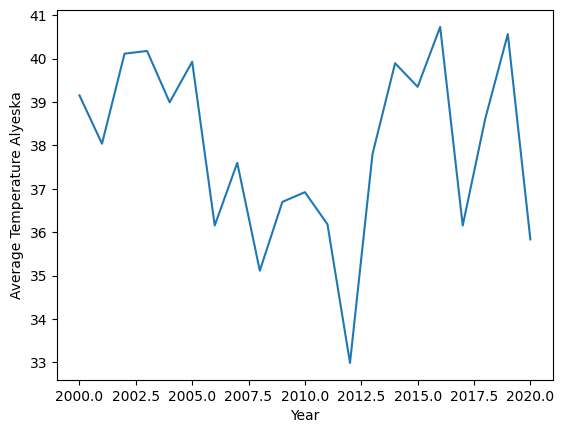

In [18]:
# plot this data
# use a line plot as we are seeing trends over time
sb.lineplot(x="Year",y="Average Temperature",data=AlyeskaTempDF)
plt.ylabel("Average Temperature Alyeska")

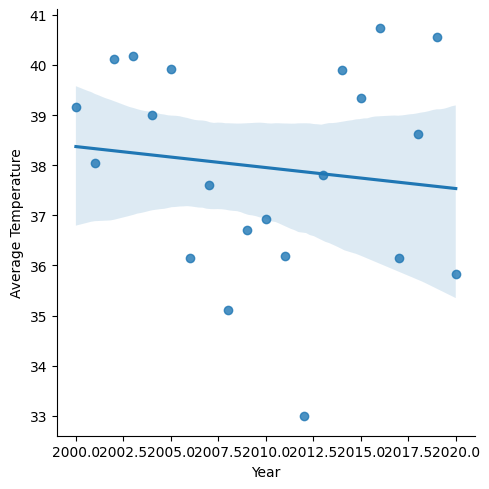

In [19]:
# we can then use a lmplot to get the regression line, and see if over those 20 years we see an increase of temperature
sb.lmplot(x="Year",y="Average Temperature",data=AlyeskaTempDF)

In [20]:
# For the Alyeska ski resort, there is not the strongest trend of an increasing temperature
# Let's see if any of the other resorts show any strong trends 
# I am going to repeat this process for the other four ski resorts that I am focusing on. It is the same code as above,
# just with different .iloc values and different names 

In [21]:
average_temperatures_Crystal = {year: calculateMeanTemperature(resortsDF.iloc[1]["lat"],resortsDF.iloc[1]["lon"],year)
                        for year in range(start_year, end_year + 1)}

In [22]:
CrystalTempDF = getDF(average_temperatures_Crystal)

Text(0, 0.5, 'Average Temperature Crystal Mt')

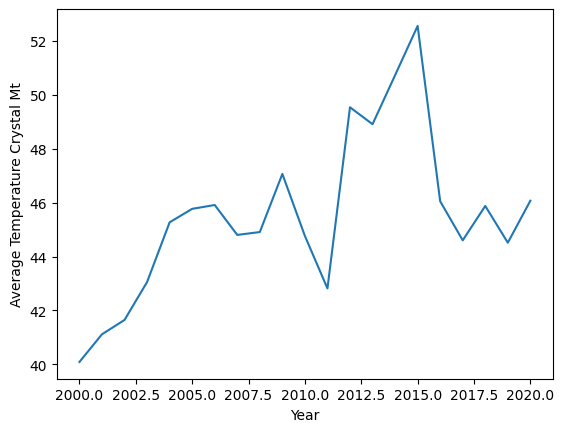

In [23]:
sb.lineplot(x="Year",y="Average Temperature",data=CrystalTempDF)
plt.ylabel("Average Temperature Crystal Mt")

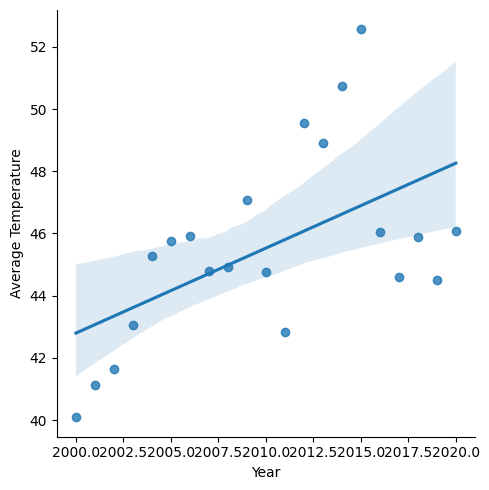

In [24]:
sb.lmplot(x="Year",y="Average Temperature",data=CrystalTempDF)

In [25]:
# There is a lot stronger regression line/trend of the average temperatures increasing throughout the past 20 years at Crystal Mountian
# Let's keep it going for the other resorts 

In [26]:
average_temperatures_Mammoth = {year: calculateMeanTemperature(resortsDF.iloc[2]["lat"],resortsDF.iloc[2]["lon"],year)
                        for year in range(start_year, end_year + 1)}

In [27]:
MammothDF = getDF(average_temperatures_Mammoth)

Text(0, 0.5, 'Average Temperature Mammoth')

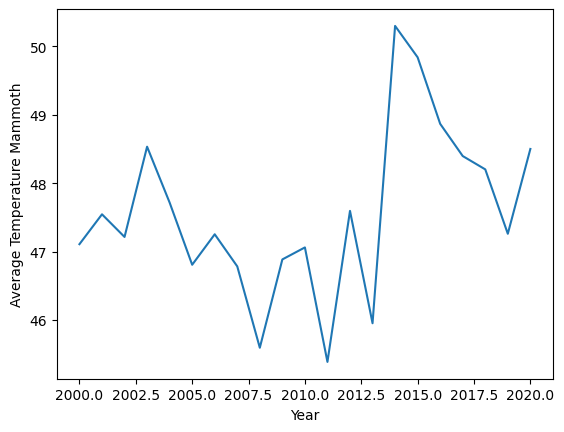

In [28]:
sb.lineplot(x="Year",y="Average Temperature",data=MammothDF)
plt.ylabel("Average Temperature Mammoth")

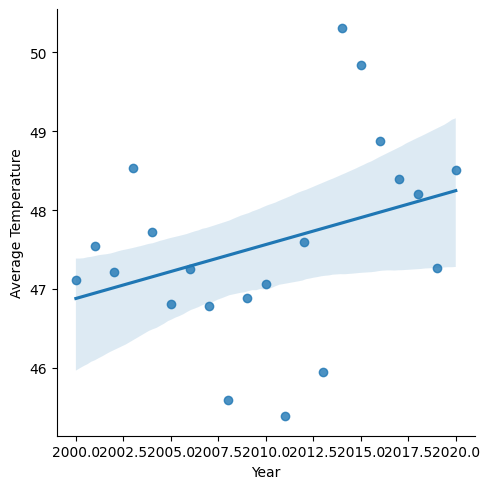

In [29]:
sb.lmplot(x="Year",y="Average Temperature",data=MammothDF)

In [30]:
# Mammoth is also showing a positive correlation line 

In [31]:
average_temperatures_Steamboat = {year: calculateMeanTemperature(resortsDF.iloc[3]["lat"],resortsDF.iloc[3]["lon"],year)
                        for year in range(start_year, end_year + 1)}

In [32]:
SteamboatDF = getDF(average_temperatures_Steamboat)

Text(0, 0.5, 'Average Temperature Steamboat')

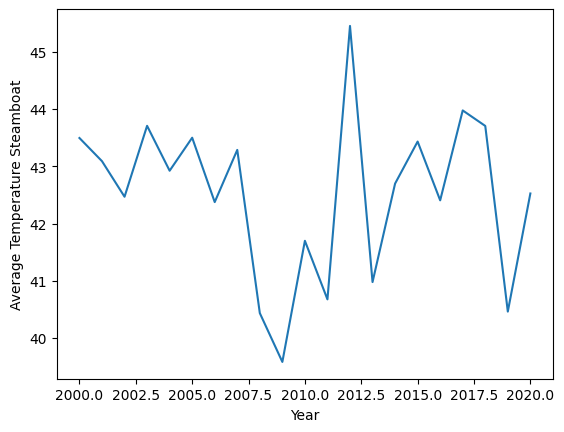

In [33]:
sb.lineplot(x="Year",y="Average Temperature",data=SteamboatDF)
plt.ylabel("Average Temperature Steamboat")

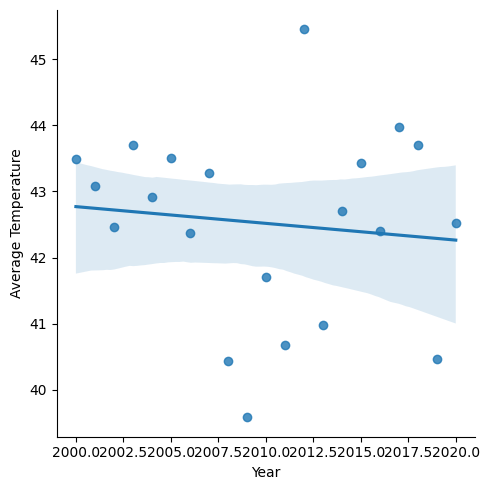

In [34]:
sb.lmplot(x="Year",y="Average Temperature",data=SteamboatDF)

In [35]:
# Steamboat regression looks more similar to Alyeska's. Interesting. Later I want to see if this has anything to do with 
# precipitation levels 

# let's look at our last resorts: vail

In [36]:
average_temperatures_Vail = {year: calculateMeanTemperature(resortsDF.iloc[4]["lat"],resortsDF.iloc[4]["lon"],year)
                        for year in range(start_year, end_year + 1)}

In [37]:
VailTempDF = getDF(average_temperatures_Vail)

Text(0, 0.5, 'Average Temperature Vail')

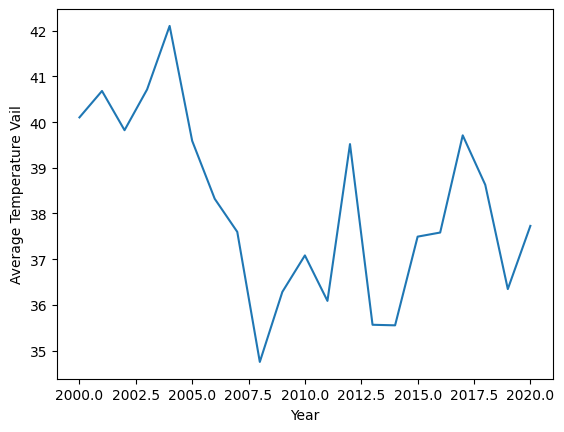

In [38]:
sb.lineplot(x="Year",y="Average Temperature",data=VailTempDF)
plt.ylabel("Average Temperature Vail")

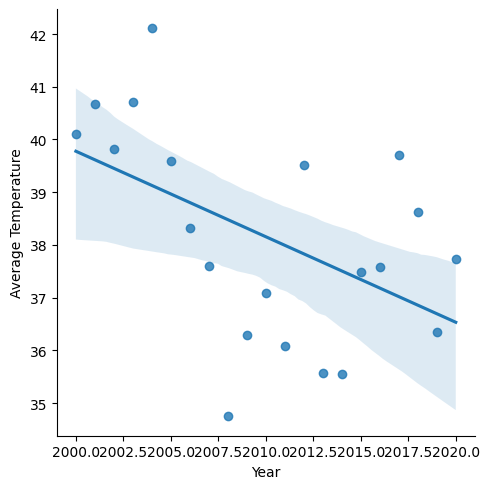

In [39]:
sb.lmplot(x="Year",y="Average Temperature",data=VailTempDF)

In [40]:
# Interesting! Vail actually has a correlation of decreasing average temperatures

In [41]:
# Alright, these graphs so some intriguing data. 

# All resorts (except for Vail) appears to have an average increasing tempertare, but they are all in different ranges of temperatures

# Let's graph the average temperature over the 20 years worth of data for each resort, and compare the 
# average temperature the the base elevation 

In [42]:
# Calculate average temperature for each ski resort using np.mean
AverageTempAlyeska = np.mean(AlyeskaTempDF["Average Temperature"])

AverageTempCrystal = np.mean(CrystalTempDF["Average Temperature"])

AverageTempMammoth = np.mean(MammothDF["Average Temperature"])

AverageTempSteamboat = np.mean(SteamboatDF["Average Temperature"])

AverageTempVail = np.mean(VailTempDF["Average Temperature"])

In [43]:
# Let's put this into a dictionary where the key will be the column name and the value will the values within that column 
AverageTemps = {"resort_name":["Alyeska, AK","Crystal Mt, WA","Mammoth, CA","Steamboat, CO","Vail,CO"],
                "Average Temperature 2000-2020":[AverageTempAlyeska,AverageTempCrystal,AverageTempMammoth,
                                                 AverageTempSteamboat,AverageTempVail]}

In [44]:
# put the information in the dictionary using pandas .DataFrame function
AverageTempsDF = pd.DataFrame(data=AverageTemps)
AverageTempsDF

,resort_name,Average Temperature 2000-2020
0,"Alyeska, AK",37.952562
1,"Crystal Mt, WA",45.527810
2,"Mammoth, CA",47.562429
3,"Steamboat, CO",42.517256
4,"Vail,CO",38.155605


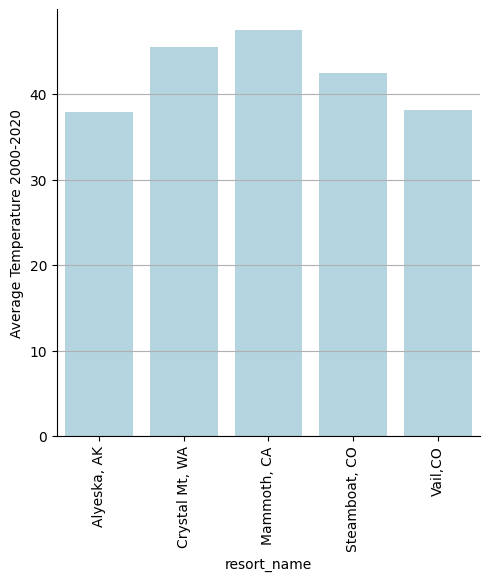

In [45]:
# And graph!! Using a bar chart again to compare 
sb.catplot(x="resort_name",y="Average Temperature 2000-2020",data=AverageTempsDF,
           kind="bar",color="lightblue").set_xticklabels(rotation=90)
plt.grid(axis="y")

In [46]:
# How does the graph above connect to the latitude the ski resorts are located at? 

# What about the base elevation?

# From the graph shown above: Alyeska has the lowest base elevation, and it also has the lowest average temperature
# Mammoth has the highest elevation, and it happens to also have the highest temperature. In the write-up, I explore the relationship 
# between these values and base elevation and/or latitude

In [47]:
# Now let's take a look at precipitation
# read new .csv file using pandas
annualSnowDF = pd.read_csv("annualsnow.csv")
annualSnowDF

,Location,Resort,Pass,Year,Total Snowfall,Snowfall Days,Average Base Depth,Average Summit Depth,Max Base Depth,Biggest Snowfall
0,utah,Alta,Ikon,2012 - 2013,"366""",76,"50""","52""","113""","17"""
1,utah,Alta,Ikon,2013 - 2014,"353""",68,"64""","60""","124""","14"""
2,utah,Alta,Ikon,2014 - 2015,"278""",56,"44""","42""","90""","19"""
3,utah,Alta,Ikon,2015 - 2016,"286""",60,"51""","51""","116""","19"""
4,utah,Alta,Ikon,2016 - 2017,"304""",55,"64""","63""","145""","19"""
...,...,...,...,...,...,...,...,...,...,...
865,wisconsin,Wilmot Mountain,Epic,2017 - 2018,"37""",15,"6""","10""","28""","8"""
866,wisconsin,Wilmot Mountain,Epic,2018 - 2019,"35""",9,"9""","15""","24""","10"""
867,wisconsin,Wilmot Mountain,Epic,2019 - 2020,"6""",1,"9""","17""","29""","6"""
868,wisconsin,Wilmot Mountain,Epic,2020 - 2021,"22""",11,"9""","10""","20""","5"""


In [48]:
# This dataframe tells the average snowfall for all the resorts on Ikon and Epic from the 2012/13 season up to the 2021/22 season
# Let's visualize this 

In [49]:
# we want to get the total snowfall for each season, but in this dataframe, the snowfall is not in an int form 
# let's use regex to create a new column where we just get the number value 
# \d is equal to a number 0-9, and + means one or more of those 
int_form = "(\d+)"

annualSnowDF["Total Snowfall (int)"] = annualSnowDF["Total Snowfall"].str.extract(int_form).astype(int)

In [50]:
# Let's see how much total snowfall each year received 
# groupby year, and then aggregate the total snowfall (int), summing each value
# reset index so that we can graph 
aveSnowFall = annualSnowDF.groupby("Year").agg({"Total Snowfall (int)":sum}).reset_index()
aveSnowFall

,Year,Total Snowfall (int)
0,2012 - 2013,21505
1,2013 - 2014,22376
2,2014 - 2015,15725
3,2015 - 2016,19906
4,2016 - 2017,23699
5,2017 - 2018,22121
6,2018 - 2019,22211
7,2019 - 2020,18035
8,2020 - 2021,14169
9,2021 - To Date,14546


<Axes: xlabel='Year', ylabel='Total Snowfall (int)'>

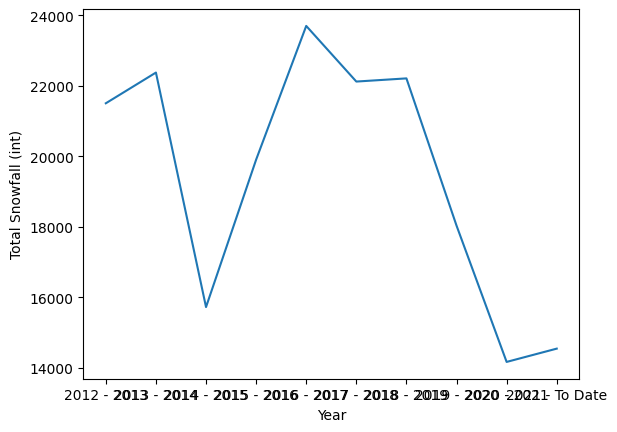

In [51]:
# now let's graph to see if the snowfall leves for each year has shown any patterns of changing
sb.lineplot(x="Year",y="Total Snowfall (int)",data=aveSnowFall)

In [52]:
# The average total snowfall does seem to be, on average, less in 2021/22 season than the 2012/2013 season,
# but there seems to be a pattern of the temperatures going down and up throughout the years 

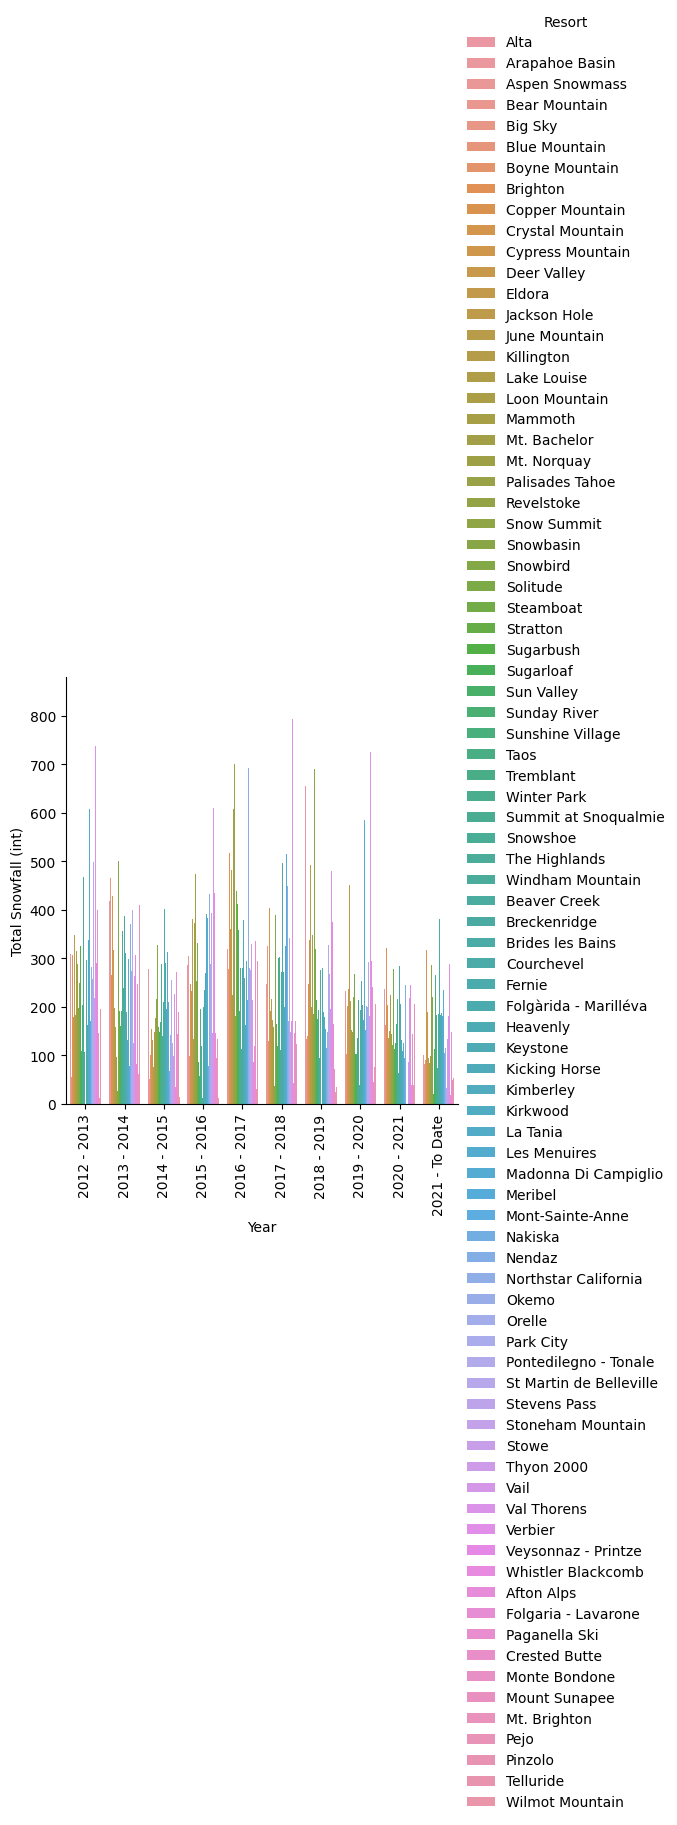

In [53]:
# Let's now narrow in to the resort level.
# we can start with seeing the total snowfall at each resort throughout the years
# same graphing process as above but now we are setting the hue="Resort". This will graph each resorts total snowfall for that year
sb.catplot(x="Year",y="Total Snowfall (int)",data=annualSnowDF,hue="Resort",kind="bar").set_xticklabels(rotation=90)

In [54]:
# That is wayyy too much visually. Let's narrow this down 
# Let's look at resorts that are just within colorado, using a boolean mask
coloradoSnowDF = annualSnowDF[annualSnowDF["Location"] == "colorado"]
coloradoSnowDF

,Location,Resort,Pass,Year,Total Snowfall,Snowfall Days,Average Base Depth,Average Summit Depth,Max Base Depth,Biggest Snowfall,Total Snowfall (int)
10,colorado,Arapahoe Basin,Ikon,2012 - 2013,"281""",93,"35""","35""","69""","14""",281
11,colorado,Arapahoe Basin,Ikon,2013 - 2014,"418""",115,"56""","55""","90""","15""",418
12,colorado,Arapahoe Basin,Ikon,2014 - 2015,"314""",98,"39""","39""","62""","19""",314
13,colorado,Arapahoe Basin,Ikon,2015 - 2016,"290""",88,"48""","48""","80""","15""",290
14,colorado,Arapahoe Basin,Ikon,2016 - 2017,"345""",89,"53""","52""","78""","18""",345
...,...,...,...,...,...,...,...,...,...,...,...
855,colorado,Telluride,Epic,2017 - 2018,"159""",37,"20""","23""","48""","12""",159
856,colorado,Telluride,Epic,2018 - 2019,"323""",63,"44""","42""","110""","19""",323
857,colorado,Telluride,Epic,2019 - 2020,"205""",48,"24""","24""","55""","19""",205
858,colorado,Telluride,Epic,2020 - 2021,"206""",49,"24""","30""","64""","17""",206


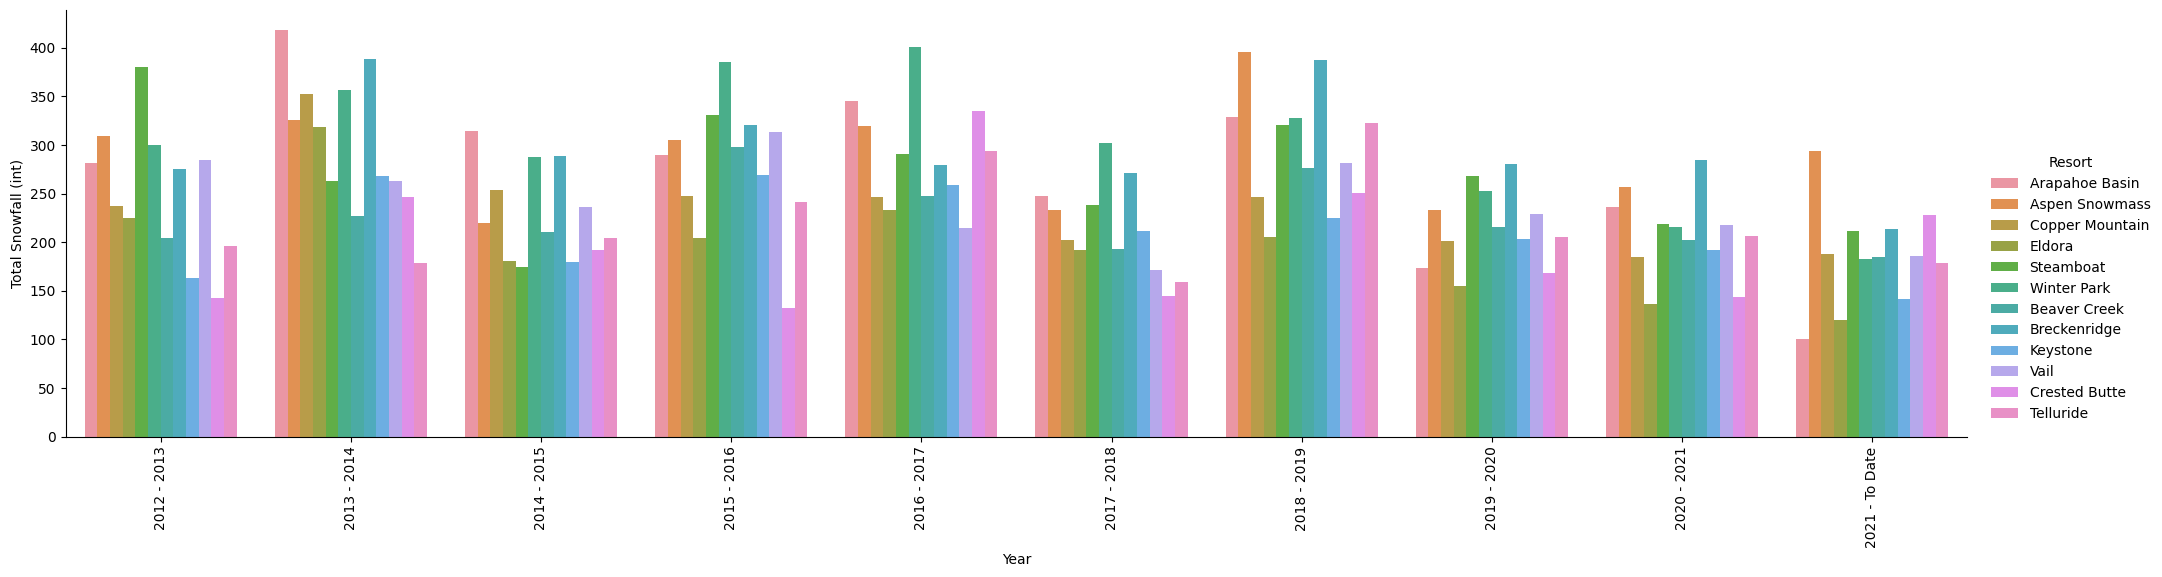

In [55]:
# now graph this
sb.catplot(x="Year",y="Total Snowfall (int)",data=coloradoSnowDF,hue="Resort",kind="bar",aspect=4).set_xticklabels(rotation=90)

In [56]:
# This graph is still slightly hard to visualize and take the data from 
# Let's use the agg function to see throughout all of the years (2012-2022) to which resort has the highest total snowfall 

# groupby the resort
# agg method: summing up the total snowfall for each resort. This will add the total snowfall from all the seasons given 
# sort values in ascending order to get the resorts with the highest total snowfall at the top 
# reset index so that we can graph accordingly 
maxSnowfall = coloradoSnowDF.groupby(["Resort"]).agg({
                    "Total Snowfall (int)":sum}).sort_values("Total Snowfall (int)",ascending=False).reset_index()
maxSnowfall

,Resort,Total Snowfall (int)
0,Winter Park,3012
1,Breckenridge,2988
2,Aspen Snowmass,2892
3,Arapahoe Basin,2733
4,Steamboat,2695
5,Vail,2397
6,Copper Mountain,2358
7,Beaver Creek,2258
8,Telluride,2186
9,Keystone,2112


In [57]:
# Let's compare the base elevation of these resorts from our original ski dataframe 
print(skiResortLocationDF[skiResortLocationDF["resort_name"] == "Winter Park, CO"]["lat"])

print(skiResortLocationDF[skiResortLocationDF["resort_name"] == "Eldora, CO"]["lat"])

354    39.88
Name: lat, dtype: float64
109    39.94
Name: lat, dtype: float64


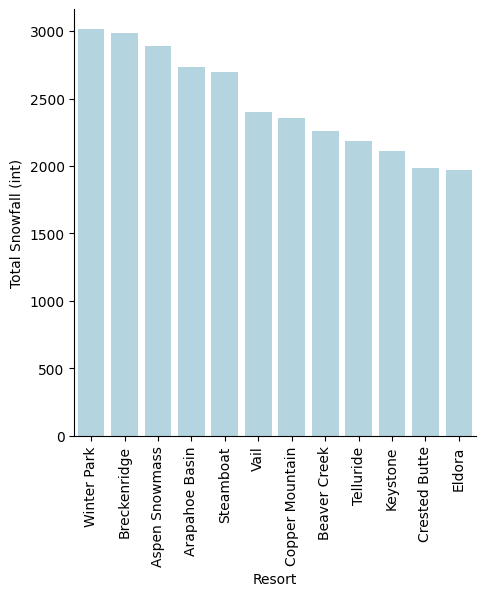

In [58]:
# Let's graph this 
# Bar plot because data for each year 
sb.catplot(x="Resort",y="Total Snowfall (int)",data=maxSnowfall,kind="bar",color="lightblue").set_xticklabels(rotation=90)

In [59]:
# That's weird, the resorts with the highest and lowest total snowfall
# have almost identical latitudes....so maybe we should take into consideration the size of these resorts (bigger the resort,
# more snow they will record)
# We can do this by taking the acres from the first data frame we worked with, using a boolean mask and then extracting the 
# "acres" values
print(skiResortLocationDF[skiResortLocationDF["resort_name"] == "Winter Park, CO"]["acres"])

print(skiResortLocationDF[skiResortLocationDF["resort_name"] == "Eldora, CO"]["acres"])

354    3078
Name: acres, dtype: int64
109    680
Name: acres, dtype: int64


In [60]:
# Yes, that makes a lot more sense, Eldora is a lot smaller in terms of acres, so they would report less snowfall
# Let's try to compare the average snowfall to resorts that have similar sizes 

In [61]:
# Let's look at the ski resorts that are in between 2000 acres and less than 3000 acres and within Colorado
# use multiple boolean masks to get the resorts with acres greater than 2000 but less than 3000, all within Colorado
# reset index to use .iloc later on
COAcres = skiResortLocationDF[(skiResortLocationDF["acres"] >= 2000) & (skiResortLocationDF["acres"] <= 3000) & 
                    (skiResortLocationDF["state"] == "Colorado")].reset_index()
COAcres

,index,resort_name,state,summit,base,vertical,lifts,runs,acres,green_percent,green_acres,blue_percent,blue_acres,black_percent,black_acres,lat,lon
0,55,"Breckenridge, CO",Colorado,12998.0,9600.0,3398.0,31.0,155.0,2358,0.14,330.12,0.31,730.98,0.55,1296.9,39.49,-106.03
1,89,"Copper Mt, CO",Colorado,12313.0,9712.0,2601.0,22.0,127.0,2465,0.21,517.65,0.25,616.25,0.54,1331.1,39.46,-106.17
2,293,"Steamboat, CO",Colorado,10568.0,6900.0,3668.0,18.0,165.0,2965,0.14,415.10,0.42,1245.30,0.44,1304.6,40.80,-106.95
3,314,"Telluride, CO",Colorado,13320.0,8750.0,4570.0,18.0,118.0,2000,0.23,460.00,0.36,720.00,0.41,820.0,37.94,-107.82


In [62]:
# Let's look at the total snowfall at these resorts (Doing the ones I know for sure on the epic and Ikon pass)
# We can use our annualsnow.csv file for this

# hard coding the resort names based on the result from the last cell
resorts = ["Breckenridge","Copper Mountain","Telluride","Steamboat"]
# use .isin() function to get these resorts 
newColoradoSnow = coloradoSnowDF[coloradoSnowDF["Resort"].isin(resorts)]
newColoradoSnow

,Location,Resort,Pass,Year,Total Snowfall,Snowfall Days,Average Base Depth,Average Summit Depth,Max Base Depth,Biggest Snowfall,Total Snowfall (int)
80,colorado,Copper Mountain,Ikon,2012 - 2013,"237""",77,"29""","28""","80""","13""",237
81,colorado,Copper Mountain,Ikon,2013 - 2014,"352""",87,"42""","47""","91""","18""",352
82,colorado,Copper Mountain,Ikon,2014 - 2015,"254""",63,"35""","39""","70""","17""",254
83,colorado,Copper Mountain,Ikon,2015 - 2016,"247""",71,"33""","40""","76""","15""",247
84,colorado,Copper Mountain,Ikon,2016 - 2017,"246""",70,"32""","39""","64""","16""",246
85,colorado,Copper Mountain,Ikon,2017 - 2018,"202""",59,"29""","37""","73""","18""",202
86,colorado,Copper Mountain,Ikon,2018 - 2019,"246""",69,"37""","52""","87""","19""",246
87,colorado,Copper Mountain,Ikon,2019 - 2020,"201""",65,"23""","32""","61""","17""",201
88,colorado,Copper Mountain,Ikon,2020 - 2021,"185""",76,"23""","27""","50""","9""",185
89,colorado,Copper Mountain,Ikon,2021 - To Date,"188""",61,"41""","48""","62""","13""",188


In [63]:
# Let's group and graph this data 
# same process as above but with selected ski resorts 
newAgg = newColoradoSnow.groupby(["Resort"]).agg({
                    "Total Snowfall (int)":sum}).sort_values("Total Snowfall (int)",ascending=False).reset_index()

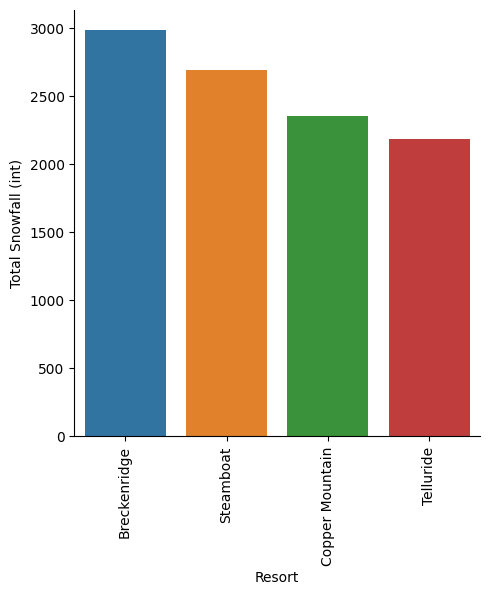

In [64]:
sb.catplot(x="Resort",y="Total Snowfall (int)",data=newAgg,kind="bar").set_xticklabels(rotation=90)

In [65]:
# Alright, now we can see a difference in total snowfall. Let's see if this has any relation at all to the latitude these resorts
# are located at 

# Let's display the latitude for each of these resorts
for i in range(0,4):
    print("Resort Name: "+COAcres.loc[i]["resort_name"]+" Latitude: "+str(COAcres.iloc[i]["lat"]))

Resort Name: Breckenridge, CO Latitude: 39.49
Resort Name: Copper Mt, CO Latitude: 39.46
Resort Name: Steamboat, CO Latitude: 40.8
Resort Name: Telluride, CO Latitude: 37.94


In [66]:
# The resorts (in Colorado) with the highest total snowfall from 2013-2022 have the highest latitudes compared 
# to the resorts that reported the lowest snowfall comparitavely. 

# Let's now look at how the original five resorts compare to each other in terms of precipitation

In [67]:
# let's get those resorts so we can extract just those resorts into a dataframe 
resorts2 = ["Alyeska","Mammoth","Crystal Mountain","Steamboat","Vail"]

# unfortunately this dataframe does not include Alyeska, even though it is on the Ikon pass. We'll just have to compare data to the 
# other resorts 
ogResorts = annualSnowDF[annualSnowDF["Resort"].isin(resorts2)]
ogResorts

,Location,Resort,Pass,Year,Total Snowfall,Snowfall Days,Average Base Depth,Average Summit Depth,Max Base Depth,Biggest Snowfall,Total Snowfall (int)
90,washington,Crystal Mountain,Ikon,2012 - 2013,"838""",104,"47""","82""","79""","52""",838
91,washington,Crystal Mountain,Ikon,2013 - 2014,"429""",81,"32""","72""","80""","38""",429
92,washington,Crystal Mountain,Ikon,2014 - 2015,"154""",41,"7""","25""","30""","14""",154
93,washington,Crystal Mountain,Ikon,2015 - 2016,"409""",78,"40""","63""","90""","21""",409
94,washington,Crystal Mountain,Ikon,2016 - 2017,"388""",88,"38""","53""","84""","19""",388
95,washington,Crystal Mountain,Ikon,2017 - 2018,"403""",78,"38""","59""","750""","16""",403
96,washington,Crystal Mountain,Ikon,2018 - 2019,"377""",77,"33""","49""","443""","26""",377
97,washington,Crystal Mountain,Ikon,2019 - 2020,"326""",57,"43""","41""","96""","20""",326
98,washington,Crystal Mountain,Ikon,2020 - 2021,"406""",62,"60""","77""","133""","41""",406
99,washington,Crystal Mountain,Ikon,2021 - To Date,"317""",49,"47""","55""","94""","34""",317


In [68]:
# let's see the total snowfall and the snowfall days for these resorts 
# first we'll groupby the year and the resort to see how it changed over the years, and then we can look at the entire 
# total for the years 2013-22

In [69]:
overTheYears = ogResorts.groupby(["Resort","Year"]).agg({"Total Snowfall (int)":sum}).reset_index()
overTheYears

,Resort,Year,Total Snowfall (int)
0,Crystal Mountain,2012 - 2013,838
1,Crystal Mountain,2013 - 2014,429
2,Crystal Mountain,2014 - 2015,154
3,Crystal Mountain,2015 - 2016,409
4,Crystal Mountain,2016 - 2017,388
5,Crystal Mountain,2017 - 2018,403
6,Crystal Mountain,2018 - 2019,377
7,Crystal Mountain,2019 - 2020,326
8,Crystal Mountain,2020 - 2021,406
9,Crystal Mountain,2021 - To Date,317


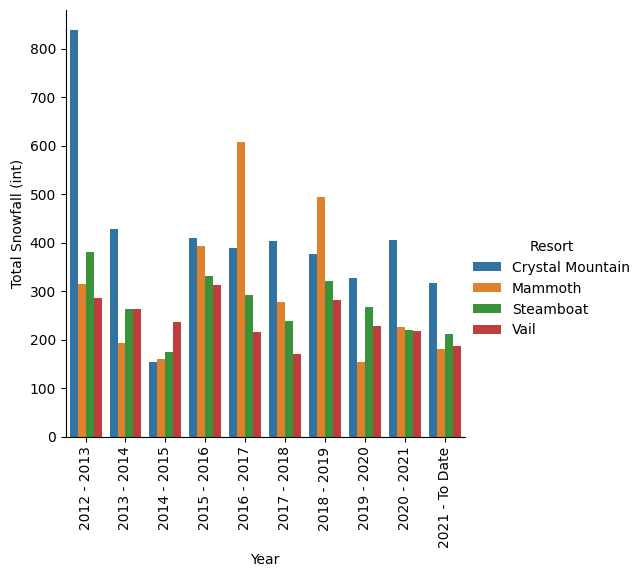

In [70]:
sb.catplot(x="Year",y="Total Snowfall (int)",data=overTheYears,hue="Resort",kind="bar").set_xticklabels(rotation=90)

In [71]:
# It appears that overall, Crystal and Mammoth were receiving the most snowfall (in inches) each year,
# while Vail appears to, on average, received the lowest total snowfall (in inches)

# Let's sum all of the years together to see who has received the most total snowfall 

In [72]:
# to do this, it is the same process as above but just grouping by resorts
totalSnowfallOgResorts = ogResorts.groupby("Resort").agg({"Total Snowfall (int)":sum}).reset_index()

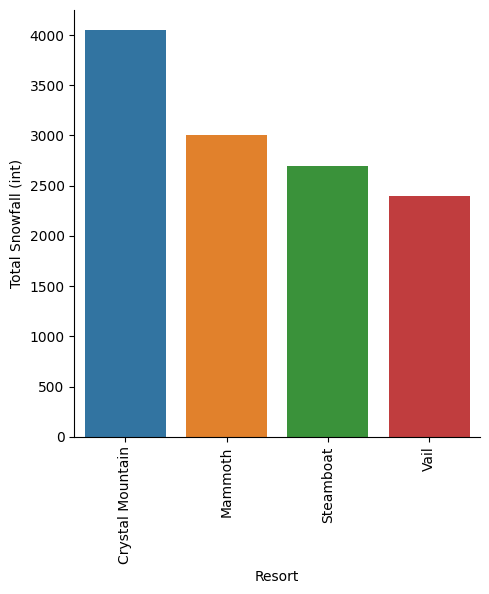

In [73]:
sb.catplot(x="Resort",y="Total Snowfall (int)",data=totalSnowfallOgResorts,kind="bar").set_xticklabels(rotation=90)

In [74]:
# Crystal Mountain clearly has received the most snow overall throughout those 10 ish years
# Lastly, let's look at the amount of days the resorts received snowfall. 

In [75]:
daysSnowedOgYears = ogResorts.groupby(["Resort","Year"]).agg({"Snowfall Days":sum}).reset_index()
daysSnowedOgYears

,Resort,Year,Snowfall Days
0,Crystal Mountain,2012 - 2013,104
1,Crystal Mountain,2013 - 2014,81
2,Crystal Mountain,2014 - 2015,41
3,Crystal Mountain,2015 - 2016,78
4,Crystal Mountain,2016 - 2017,88
5,Crystal Mountain,2017 - 2018,78
6,Crystal Mountain,2018 - 2019,77
7,Crystal Mountain,2019 - 2020,57
8,Crystal Mountain,2020 - 2021,62
9,Crystal Mountain,2021 - To Date,49


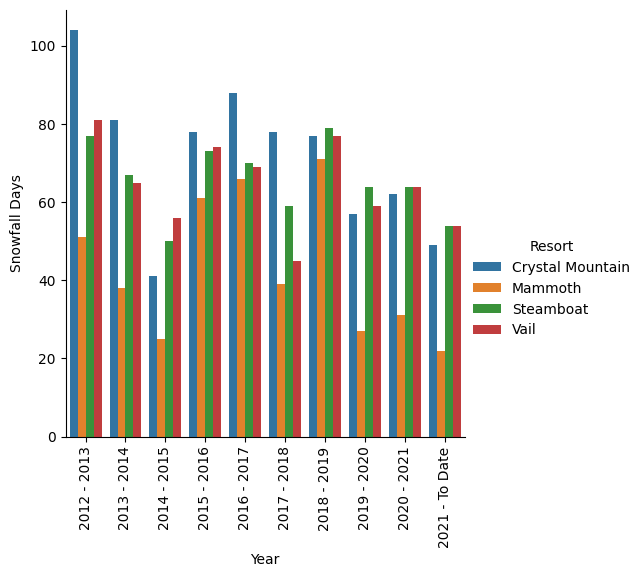

In [76]:
sb.catplot(x="Year",y="Snowfall Days",data=daysSnowedOgYears,hue="Resort",kind="bar").set_xticklabels(rotation=90)

In [77]:
# Again, Crystal appears to have the most days snowed each year, which makes sense as it reported the most snow
# However, Steamboat seems to have more days snowed even though it was one of the resorts with less total snowfall
# This graph above is slightly hard to visualize and claim which resort had the most snowfall days, so let's graph the summed values

In [78]:
# same as above but only groupby resort, not both resort and year
daysSnowedOG = ogResorts.groupby("Resort").agg({"Snowfall Days":sum}).reset_index()

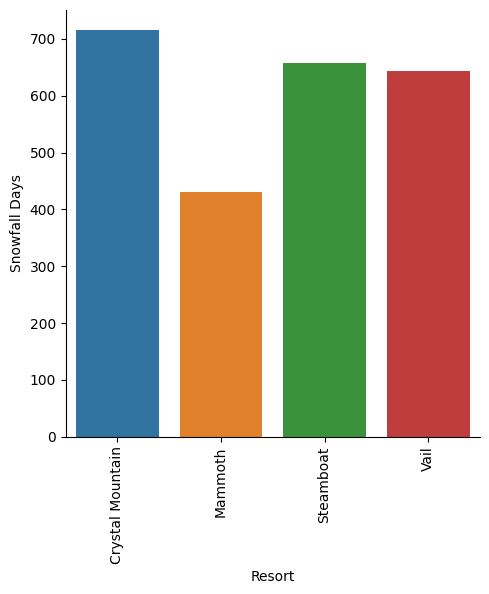

In [79]:
sb.catplot(x="Resort",y="Snowfall Days",data=daysSnowedOG,kind="bar").set_xticklabels(rotation=90)

In [80]:
# This is very interesting to see - despite Mammoth having the second most highest total snowfall, it has the least snowfall days 
# by a lot. Let's do one more thing to see how this compares before we tie this in to where the resort is located geographically:
# Let's add a column that takes the total snowfall / the total snowfall days for the entire years 
# This will show us ON AVERAGE how much snow the resort received if it snowed 

In [81]:
# add new column 
ogResorts["Average Snow Received"] = ogResorts["Total Snowfall (int)"] / ogResorts["Snowfall Days"]
ogResorts

/tmp/ipykernel_136/2438206300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ogResorts["Average Snow Received"] = ogResorts["Total Snowfall (int)"] / ogResorts["Snowfall Days"]


,Location,Resort,Pass,Year,Total Snowfall,Snowfall Days,Average Base Depth,Average Summit Depth,Max Base Depth,Biggest Snowfall,Total Snowfall (int),Average Snow Received
90,washington,Crystal Mountain,Ikon,2012 - 2013,"838""",104,"47""","82""","79""","52""",838,8.057692
91,washington,Crystal Mountain,Ikon,2013 - 2014,"429""",81,"32""","72""","80""","38""",429,5.296296
92,washington,Crystal Mountain,Ikon,2014 - 2015,"154""",41,"7""","25""","30""","14""",154,3.756098
93,washington,Crystal Mountain,Ikon,2015 - 2016,"409""",78,"40""","63""","90""","21""",409,5.243590
94,washington,Crystal Mountain,Ikon,2016 - 2017,"388""",88,"38""","53""","84""","19""",388,4.409091
95,washington,Crystal Mountain,Ikon,2017 - 2018,"403""",78,"38""","59""","750""","16""",403,5.166667
96,washington,Crystal Mountain,Ikon,2018 - 2019,"377""",77,"33""","49""","443""","26""",377,4.896104
97,washington,Crystal Mountain,Ikon,2019 - 2020,"326""",57,"43""","41""","96""","20""",326,5.719298
98,washington,Crystal Mountain,Ikon,2020 - 2021,"406""",62,"60""","77""","133""","41""",406,6.548387
99,washington,Crystal Mountain,Ikon,2021 - To Date,"317""",49,"47""","55""","94""","34""",317,6.469388


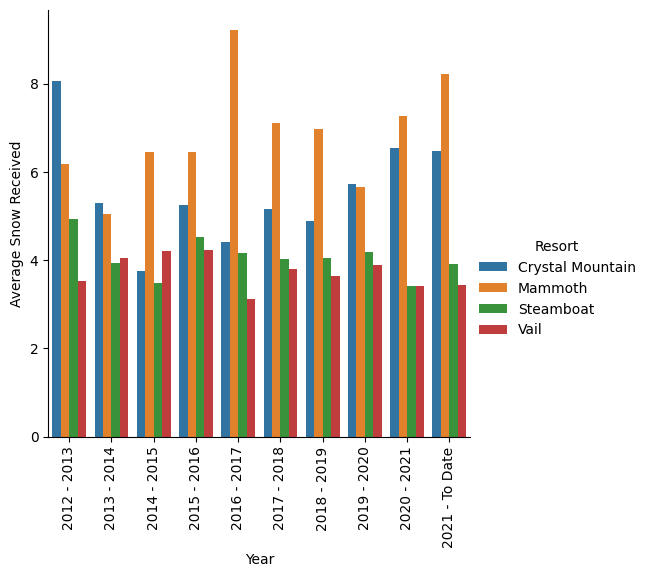

In [82]:
# This is showing us the average per each year, so let's first graph this. Then we can see the average for all 10 years 
sb.catplot(x="Year",y="Average Snow Received",data=ogResorts,kind="bar",hue="Resort").set_xticklabels(rotation=90)

In [83]:
# And let's graph the average for all of the years now

# agg will be the average snow receieved, but taking the mean for all of the years 
totalAveSnowReceived = ogResorts.groupby("Resort").agg({"Average Snow Received":np.mean}).reset_index()

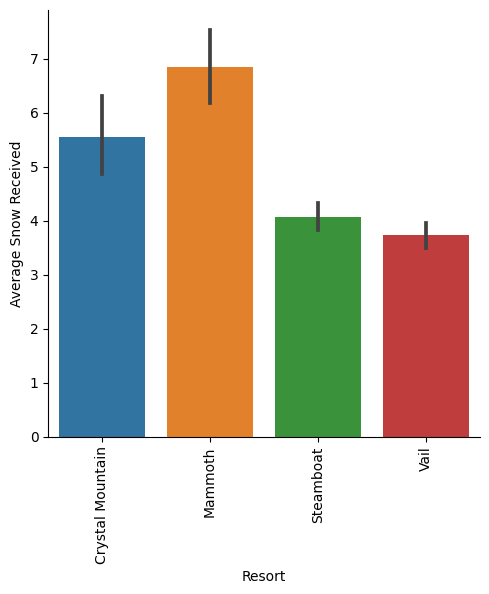

In [84]:
sb.catplot(x="Resort",y="Average Snow Received",data=ogResorts,kind="bar").set_xticklabels(rotation=90)

In [85]:
# And these results make sense! Even though mammoth had the fewest snowfall days, it was receiving on average 
# 7 inches every time that it snowed there. When it rains it pours I suppose! 
# In the write-up, I will look into to trends between where these resorts are located and this pattern of precipitation 

In [86]:
# Finally, let's look at what resorts are the most reliable or the "best" for snowfall

# to find the most reliable, graph to see which snow on average receives the most snowfall total from 2013-2022
mostSnow = annualSnowDF.groupby(["Resort","Location","Pass"]).agg({"Total Snowfall (int)"
                                                      :sum}).sort_values("Total Snowfall (int)",ascending=False).head(10)
mostSnow

,,,Total Snowfall (int)
Resort,Location,Pass,
Val Thorens,northern-alps,Epic,5683
Verbier,valais,Epic,4277
Snowbird,utah,Ikon,4151
Jackson Hole,wyoming,Ikon,4144
Crystal Mountain,washington,Ikon,4047
Mt. Bachelor,oregon,Ikon,3910
Palisades Tahoe,california,Ikon,3624
Brighton,utah,Ikon,3580
Stevens Pass,washington,Epic,3397


In [87]:
# Now what about the amount of days that it snowed 
mostDaysSnowed = annualSnowDF.groupby(["Resort","Location","Pass"]).agg({"Snowfall Days"
                                                            :sum}).sort_values("Snowfall Days",ascending=False).head(10)
mostDaysSnowed

,,,Snowfall Days
Resort,Location,Pass,
Sunshine Village,alberta,Ikon,968
Arapahoe Basin,colorado,Ikon,836
Revelstoke,british-columbia,Ikon,829
Whistler Blackcomb,british-columbia,Epic,821
Lake Louise,alberta,Ikon,790
Winter Park,colorado,Ikon,739
Breckenridge,colorado,Epic,731
Jackson Hole,wyoming,Ikon,729
Crystal Mountain,washington,Ikon,715


In [92]:
# As a fellow skier, any of these 20 resorts are great resorts to ski at, as they have the most snowfall total or 
# the most snowfall days over the past 10-ish years. 
# Crystal, Mt. Bachelor, and Jackson Hole makes both top 10 lists!! As a skier, those resorts appear to be the most reliable
# And Colorado makes the most snow days list three times, what a great place to live! 
# Also interesting to see that Ikon is the passholder for most of the resorts on both top 10 lists...
# although I grew up skiing Epic, Ikon has some compelling data here...